 <img src="https://datacube.remote-sensing.org/wp-content/uploads/2021/03/cube_namibia.png" align="left" width='70' alt="sa_logo">
          <img src="https://datacube.remote-sensing.org/wp-content/uploads/2021/02/ci_logo_navbar.png" align="right" width='180' alt="eo_logo">

## Sentinel-1: Water Detection

In [1]:
import datacube
import geopandas as gpd
from odc.ui import with_ui_cbk
import xarray as xr
import seaborn as sns
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import matplotlib.pyplot as plt

In [2]:
dc = datacube.Datacube(app = 's1_water')

In [3]:
gdf = gpd.read_file('data/example.shp')

In [4]:
longitude_extents = (gdf.total_bounds[0] , gdf.total_bounds[2] )
latitude_extents  = (gdf.total_bounds[1] , gdf.total_bounds[3] )
latitude_extents

(-25.763999530488093, -25.69548011202764)

In [7]:
# select time period
time_extents=('2019-01-01', '2019-04-24')

# select product
product = "s1_gamma0_mpumalanga"


ds_s1 = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          time = time_extents,
                          skip_broken_datasets=True,
                          product = product,
                         progress_cbk=with_ui_cbk()) 

In [8]:
ds_s1

<xarray.Dataset>
Dimensions:      (time: 26, x: 827, y: 769)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-06T03:18:46 ... 2019-04-24T03:...
  * y            (y) float64 7.15e+06 7.15e+06 7.15e+06 ... 7.157e+06 7.157e+06
  * x            (x) float64 3.468e+05 3.468e+05 ... 3.551e+05 3.551e+05
    spatial_ref  int32 32736
Data variables:
    VH           (time, y, x) float32 -10.95 -14.7 -17.08 ... -15.56 -14.54
    VV           (time, y, x) float32 -10.82 -9.92 -7.958 ... -5.23 -4.689
Attributes:
    crs:           EPSG:32736
    grid_mapping:  spatial_ref

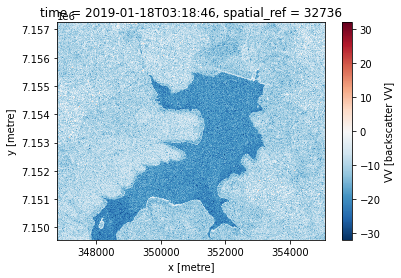

In [10]:
ds_s1.VV.isel(time=2).plot()

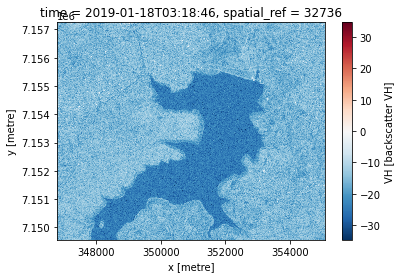

In [11]:
ds_s1.VH.isel(time=2).plot()

In [12]:
def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

<ipython-input-12-389b39091f76>:9: RuntimeWarning: invalid value encountered in true_divide
  img_weights = img_variance / (img_variance + overall_variance)


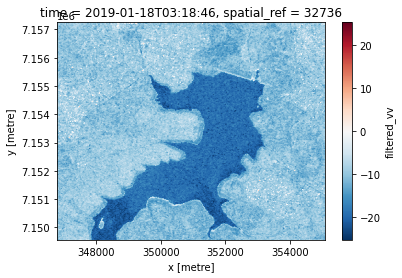

In [14]:
ds_s1_filled = ds_s1.where(~ds_s1.isnull(), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
ds_s1["filtered_vv"] = ds_s1_filled.VV.groupby("time").apply(lee_filter, size=5)
ds_s1["filtered_vh"] = ds_s1_filled.VH.groupby("time").apply(lee_filter, size=5)

subset = ds_s1.filtered_vv.isel(time = 2)
subset.plot()

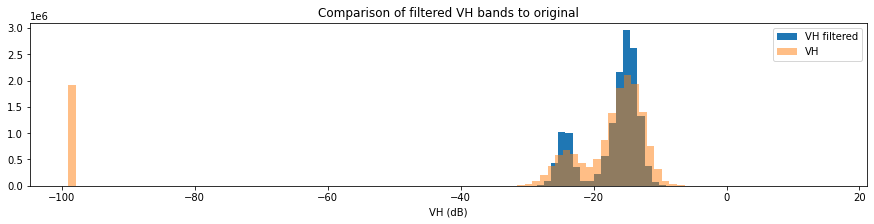

In [16]:
fig = plt.figure(figsize=(15, 3))
ds_s1.filtered_vh.plot.hist(bins=100, label="VH filtered")
ds_s1.VH.plot.hist(bins=100, label="VH", alpha=0.5)
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Comparison of filtered VH bands to original")
plt.show()

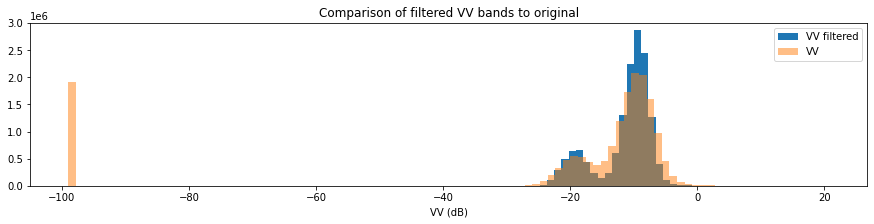

In [17]:
fig = plt.figure(figsize=(15, 3))
ds_s1.filtered_vv.plot.hist(bins=100, label="VV filtered")
ds_s1.VV.plot.hist(bins=100, label="VV", alpha=0.5)
plt.legend()
plt.xlabel("VV (dB)")
plt.title("Comparison of filtered VV bands to original")
plt.show()

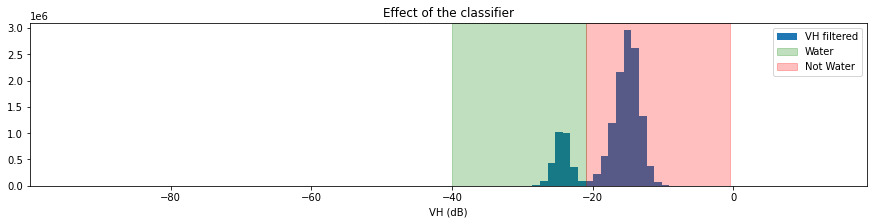

In [18]:
threshold=-21

fig, ax = plt.subplots(figsize=(15, 3))
ds_s1.filtered_vh.plot.hist(bins=100, label="VH filtered")
ax.axvspan(xmin=-40.0, xmax=threshold, alpha=0.25, color="green", label="Water")
ax.axvspan(xmin=threshold,
           xmax=-0.5,
           alpha=0.25,
           color="red",
           label="Not Water")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Effect of the classifier")
plt.show()

In [19]:
filtered = ds_s1.VH.groupby("time").apply(lee_filter, size=7)
water_data_array = filtered < threshold
ds_s1["water"] = water_data_array.to_dataset(name="s1_water").s1_water

<ipython-input-12-389b39091f76>:9: RuntimeWarning: invalid value encountered in true_divide
  img_weights = img_variance / (img_variance + overall_variance)


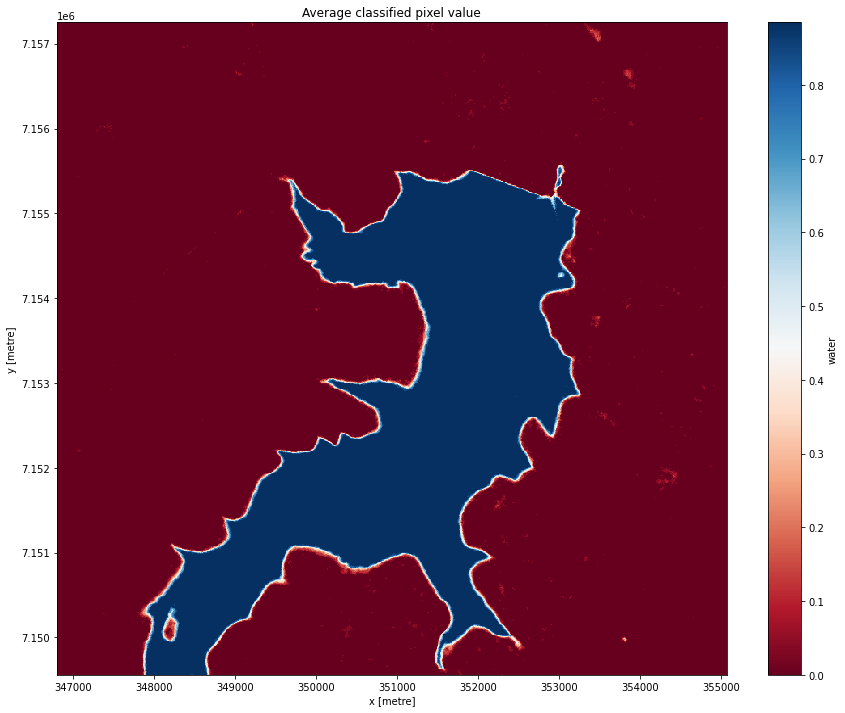

In [20]:
plt.figure(figsize=(15, 12))
ds_s1.water.mean(dim="time").plot(cmap="RdBu")
plt.title("Average classified pixel value")
plt.show()

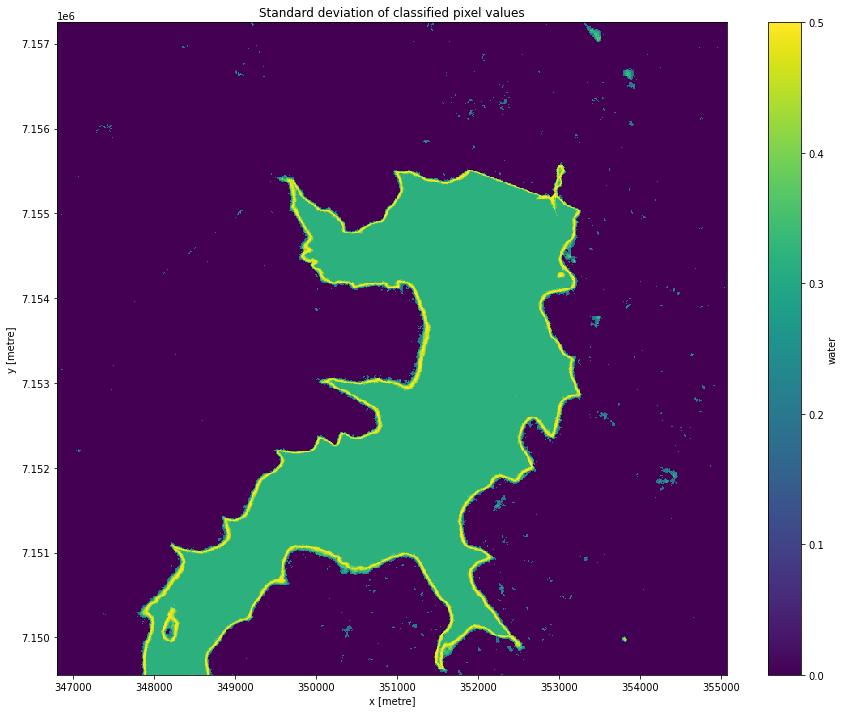

In [21]:
plt.figure(figsize=(15, 12))
ds_s1.water.std(dim="time").plot(cmap="viridis")
plt.title("Standard deviation of classified pixel values")
plt.show()